In [8]:
import os
import git
from pathlib import Path
from typing import List
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import plotly.graph_objects as go
from IPython.display import clear_output
import scipy
import pylustrator

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = True
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(os.path.join(ROOT_DIR, "results", "combined_results"))
np.random.seed(0)
plots_path = os.path.join(ROOT_DIR, "poster", "plots")

In [9]:
def variance_prior(r, eta, scale=1):
    beta = (eta+1.5)/r
    var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
    return var_prior

def kurtosis_prior(r, eta, fisher=True):
    beta = (eta+1.5)/r
    kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2 
    if fisher:
        return kurtosis - 3
    else:
        return kurtosis 

fixed_palette = {
    'gray': 'xkcd:gray',
    'green': 'xkcd:shamrock green',
    'red': 'xkcd:light red',
    'blue': 'xkcd:blue',
}

def find_master_dfs(root_dir: str) -> List[str]:
    root_path = Path(root_dir)
    if not root_path.exists():
        raise FileNotFoundError(f"Directory not found: {root_dir}")

    master_df_paths = []
    for current_dir, _, files in os.walk(root_path):
        if 'master_df.csv' in files:
            master_df_path = Path(os.path.join(current_dir, 'master_df.csv'))
            master_df_paths.append(str(master_df_path.absolute()))
    return master_df_paths

relevant_cols = ['group', 'obs_var', 'var_lower', 'var_upper', 'obs_kurt', 'kurt_lower',
       'kurt_upper', 'total_samples', 'initial_r', 'initial_eta',
       'kstest_stat_initial', 'kstest_stat_cutoff_0.05',
       'best_r', 'best_eta', 'kstest_stat_best', 'param_gaussian',
       'kstest_stat_gaussian', 'kstest_pval_gaussian', 'param_laplace',
       'kstest_stat_laplace', 'kstest_pval_laplace', 'param_t',
       'kstest_stat_t', 'kstest_pval_t', 'kstest_pval_gengamma', 'dataset', 'subset', 'transform', 'orientation', 'channel']


all_paths = find_master_dfs(os.path.join("..", "case-studies"))
all_master_dfs = []

for path in all_paths:
    if 'experiments' in path:
        continue
    master_df = pd.read_csv(path, dtype={'total_samples' : int})
    master_df = master_df.rename(columns={master_df.columns[0]: 'group'})
    master_df['total_samples'] = master_df['total_samples'] // 10 # TODO: Hacky Fix since floats in CSVs are being read in incorrectly

    parts = Path(path).parts[9:]
    if len(parts) > 6:
        dataset, size, transform, orientation, channel, _, _ = parts
        master_df['orientation'] = orientation
    else:
        dataset, size, transform, channel, _, _ = Path(path).parts[9:]
    master_df['dataset'] = dataset
    master_df['transform'] = transform
    master_df['subset'] = size
    master_df['channel'] = channel
    master_df['orientation'] = np.nan

    all_master_dfs.append(master_df[relevant_cols])
    
main_df = pd.concat(all_master_dfs)
# main_df['prior_var'] = main_df.apply(lambda row : variance_prior(row.loc['best_r'], row.loc['best_eta']), axis = 1)
# main_df['prior_kurt'] = main_df.apply(lambda row : kurtosis_prior(row.loc['best_r'], row.loc['best_eta']), axis = 1)
# main_df['gaussian_kurt'] = np.zeros(main_df.shape[0])
# main_df['laplace_kurt'] = 3*np.ones(main_df.shape[0])
main_df['best_beta'] = (main_df['best_eta'] + 1.5)/main_df['best_r'] 
main_df['kstest_stat_cutoff_0.50'] = stats.kstwo(n=main_df['total_samples']).isf(0.5)
main_df['kstest_stat_cutoff_0.10'] = stats.kstwo(n=main_df['total_samples']).isf(0.1)
main_df['kstest_stat_cutoff_0.01'] = stats.kstwo(n=main_df['total_samples']).isf(0.01)

frequency_map = pd.read_csv(os.path.join(ROOT_DIR, "transformed-data", "master-frequency-map.csv")).set_index(['dataset', 'transform', 'group'])
main_df = main_df.set_index(['dataset', 'transform', 'group']).merge(frequency_map, left_index = True, right_index=True).reset_index()

# Just including pastis, agriVision, spaceNet for Data Science Symposium Poster
main_df = main_df[(main_df['dataset'] == 'pastis') | (main_df['dataset'] == 'agriVision') | (main_df['dataset'] == 'spaceNet')]
main_df

c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\scipy\stats\_continuous_distns.py:209: RuntimeWarning: divide by zero encountered in divide
  return (0.5/(n if not isinstance(n, Iterable) else np.asanyarray(n)),
c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\scipy\stats\_continuous_distns.py:209: RuntimeWarning: divide by zero encountered in divide
  return (0.5/(n if not isinstance(n, Iterable) else np.asanyarray(n)),
c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\scipy\stats\_continuous_distns.py:209: RuntimeWarning: divide by zero encountered in divide
  return (0.5/(n if not isinstance(n, Iterable) else np.asanyarray(n)),


,dataset,transform,group,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,...,kstest_pval_t,kstest_pval_gengamma,subset,orientation,channel,best_beta,kstest_stat_cutoff_0.50,kstest_stat_cutoff_0.10,kstest_stat_cutoff_0.01,frequency
0,agriVision,fourier,2.0,1292.946700,749.107670,2108.430700,421.841550,123.974430,696.238040,4500,...,1.382990e-14,0.018082,full,NaN,blue,38.000000,0.012300,0.018207,0.024225,0.008394
1,agriVision,fourier,5.0,662.654400,382.089750,1248.617800,628.030000,108.212240,1663.239500,11700,...,3.910420e-23,0.007144,full,NaN,blue,43.333333,0.007637,0.011300,0.015033,0.013218
2,agriVision,fourier,8.0,256.633900,133.792040,650.845600,1363.730700,99.365600,3639.235800,18900,...,2.031100e-27,0.000112,full,NaN,blue,53.333333,0.006011,0.008893,0.011830,0.020181
3,agriVision,fourier,11.0,121.961570,57.215298,390.192930,2698.317600,93.680930,4889.278000,49500,...,1.306640e-42,0.000013,full,NaN,blue,55.555556,0.003716,0.005497,0.007312,0.030472
4,agriVision,fourier,14.0,48.468010,23.179575,151.679550,2654.295200,86.305040,4711.629400,113400,...,1.510880e-83,0.000004,full,NaN,blue,56.666667,0.002456,0.003633,0.004832,0.046298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,spaceNet,wavelet,5.0,373.972200,342.441220,410.995540,10.399797,6.170470,30.039886,114953,...,0.000000e+00,0.000000,full,NaN,red,0.043478,0.002439,0.003608,0.004799,0.199222
225,spaceNet,wavelet,6.0,90.558690,82.759690,99.775560,11.086198,6.617087,28.133839,425125,...,0.000000e+00,0.000000,full,NaN,red,0.057692,0.001269,0.001877,0.002496,0.249027
226,spaceNet,wavelet,7.0,20.864292,18.736567,23.678108,18.333368,9.082987,60.114044,1700500,...,0.000000e+00,0.000000,full,NaN,red,0.083333,0.000635,0.000938,0.001248,0.332036
227,spaceNet,wavelet,8.0,4.537877,3.986680,5.319919,28.597765,12.662612,99.220190,6802000,...,0.000000e+00,0.000000,full,NaN,red,1.219512,0.000317,0.000469,0.000624,0.498054


## Where do these parameters lie?

In [10]:
fontsize = 20
markersize = 70
labelsize = 20

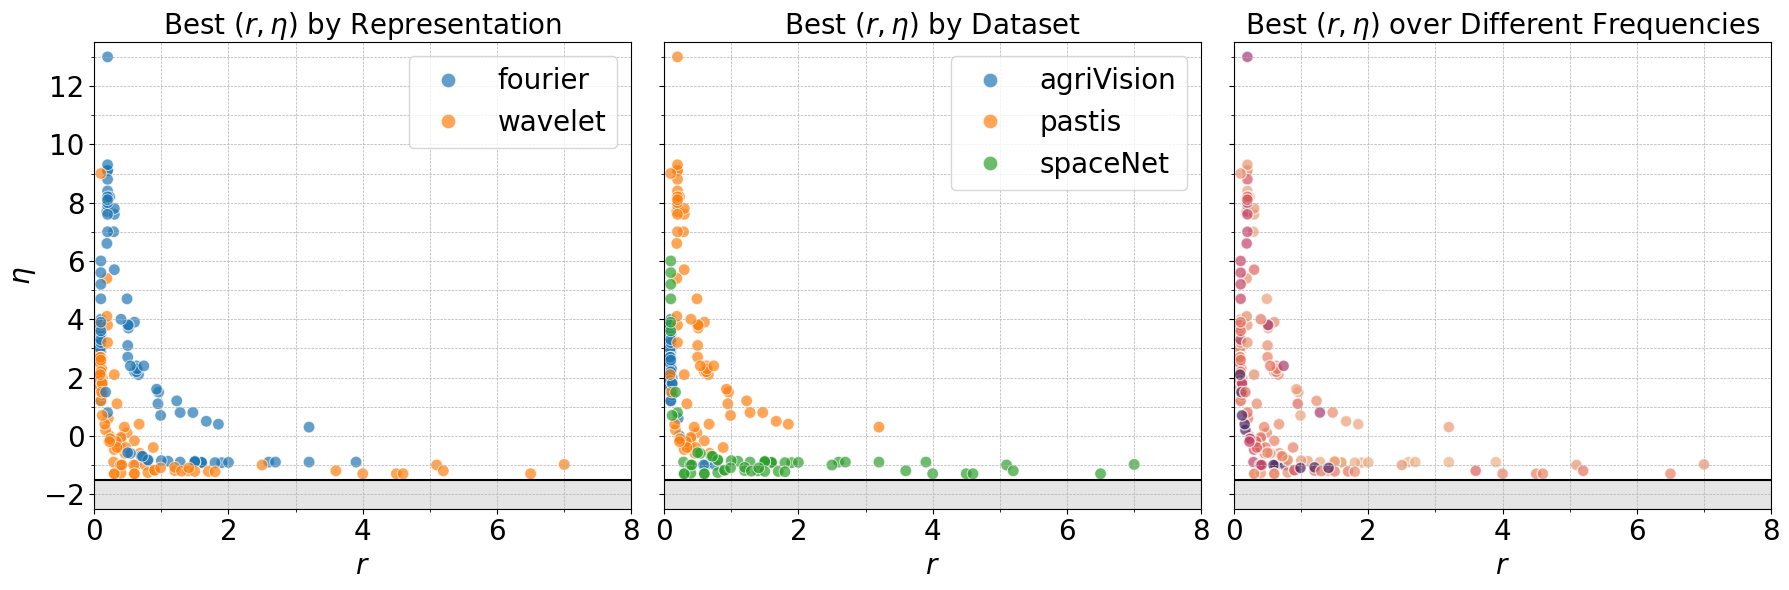

In [11]:
from matplotlib.ticker import MultipleLocator

colors = {
    'shaded_region': 'grey',
    'variance_level_set': 'green',
    'laplace': 'blue',
    'cauchy': 'xkcd:dark orange',
    'student_t': 'xkcd:dark orange',
    'axis_arrows': 'black',
    'annotation': 'black'
}

plot_config = {
    'x_limits': (0, 8),
    'y_limits': (-2.5, 13.5),
    'font_multiplier': 1,
    'font_addition': 5,
    'linewidth': 2,
    'figsize': (10, 6)
}

x_limits = plot_config['x_limits']
y_limits = plot_config['y_limits']
font_size = plot_config['font_multiplier']*12 + plot_config['font_addition']

label_r = r'$r$'
label_eta = r'$\eta$'
label_laplace = r'Laplace $(0, \frac{1}{\sqrt{2}})$'
label_student_t = r'Student t ($\nu=2$)'
label_cauchy = r'Cauchy (0, 1)'
label_variance_level_sets = 'Variance Level Sets'
label_previous_region_of_interest = 'Previous Region of Interest'
title_comparison = 'Comparison to Commonly Used Priors'

x_shade_roi = np.array([0, 4])
y_shade_roi = np.array([-0.1, 0.1])

temp = main_df
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax in (ax1, ax2, ax3):
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xlabel(r'$r$', fontsize=fontsize)

    x_shade = np.array([0, plot_config['x_limits'][1]])
    y_shade = np.array([-1.5, -1.5])
    ax.fill_between(x_shade, plot_config['y_limits'][0], y_shade, color=colors['shaded_region'], alpha=0.2)
    ax.plot(x_shade, y_shade, 'k-', linewidth=1.5)

    x_shade = np.array([plot_config['x_limits'][0], 0])
    y_shade = np.array([-1.5, -1.5])
    ax.fill_between(x_shade, y_shade, plot_config['y_limits'][1], color=colors['shaded_region'], alpha=0.2)
    ax.plot(x_shade, y_shade, 'k-', linewidth=1.5)

sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='transform', ax=ax1, alpha=0.7, s=markersize)
ax1.set_title(r'Best ($r, \eta$) by Representation', fontsize=fontsize)
ax1.set_ylabel(r'$\eta$', fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)

sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='dataset', ax=ax2, alpha=0.7, s=markersize)
ax2.set_title(r'Best ($r, \eta$) by Dataset', fontsize=fontsize)
ax2.set_ylabel('', fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=labelsize)

scatter = ax3.scatter(temp['best_r'], temp['best_eta'], 
                     c=temp['frequency'], 
                     cmap='flare',
                     s=markersize, 
                     alpha=0.7, edgecolor='white')  # Set color scale range

# # Create smaller colorbar in the top right
# colorbar = plt.colorbar(scatter, ax=ax3, 
#                        fraction=0.1,     # Make colorbar smaller
#                        pad=-0,           # Adjust spacing from plot
#                        location='right',
#                        aspect=6)           # Make colorbar more compact
# colorbar.set_label('Frequency', fontsize=fontsize)
# colorbar.ax.tick_params(labelsize=labelsize)

ax3.set_title(r'Best ($r, \eta$) over Different Frequencies', fontsize=fontsize)
ax3.set_ylabel('', fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=labelsize)

ax1.legend(markerscale=1.25, fontsize=fontsize)
ax2.legend(markerscale=1.25, fontsize=fontsize)
plt.tight_layout()
plt.show()

if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, "cdss_best_r_eta_1.jpg"), dpi=1000, bbox_inches='tight')

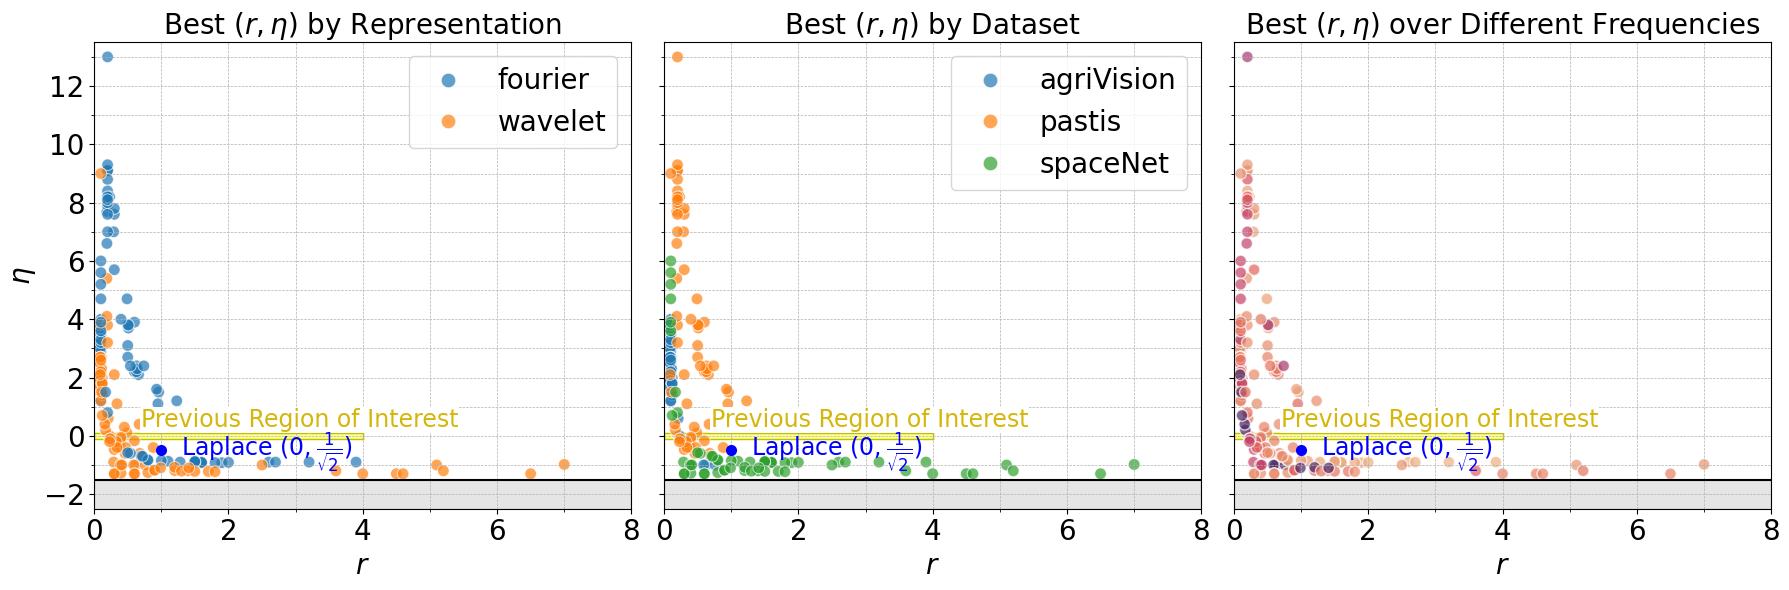

In [12]:
from matplotlib.ticker import MultipleLocator

colors = {
    'shaded_region': 'grey',
    'variance_level_set': 'green',
    'laplace': 'blue',
    'cauchy': 'xkcd:dark orange',
    'student_t': 'xkcd:dark orange',
    'axis_arrows': 'black',
    'annotation': 'black'
}

plot_config = {
    'x_limits': (0, 8),
    'y_limits': (-2.5, 13.5),
    'font_multiplier': 1,
    'font_addition': 5,
    'linewidth': 2,
    'figsize': (10, 6)
}

x_limits = plot_config['x_limits']
y_limits = plot_config['y_limits']
font_size = plot_config['font_multiplier']*12 + plot_config['font_addition']

label_r = r'$r$'
label_eta = r'$\eta$'
label_laplace = r'Laplace $(0, \frac{1}{\sqrt{2}})$'
label_student_t = r'Student t ($\nu=2$)'
label_cauchy = r'Cauchy (0, 1)'
label_variance_level_sets = 'Variance Level Sets'
label_previous_region_of_interest = 'Previous Region of Interest'
title_comparison = 'Comparison to Commonly Used Priors'

x_shade_roi = np.array([0, 4])
y_shade_roi = np.array([-0.1, 0.1])

temp = main_df
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # Adjusted total figsize

for ax in (ax1, ax2, ax3):
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xlabel(r'$r$', fontsize=fontsize)

    x_shade = np.array([0, plot_config['x_limits'][1]])
    y_shade = np.array([-1.5, -1.5])
    ax.fill_between(x_shade, plot_config['y_limits'][0], y_shade, color=colors['shaded_region'], alpha=0.2)
    ax.plot(x_shade, y_shade, 'k-', linewidth=1.5)

    x_shade = np.array([plot_config['x_limits'][0], 0])
    y_shade = np.array([-1.5, -1.5])
    ax.fill_between(x_shade, y_shade, plot_config['y_limits'][1], color=colors['shaded_region'], alpha=0.2)
    ax.plot(x_shade, y_shade, 'k-', linewidth=1.5)

    # Add Laplace
    ax.scatter(1, -0.5, color=colors['laplace'], linewidth=plot_config['linewidth'], zorder=10)
    ax.annotate(label_laplace, xy=(plot_config['x_limits'][1], -1), xytext=(1.3, -0.7), 
        textcoords='data', color=colors['laplace'], fontsize=font_size, zorder=10)
    
    # Add narrow lightly shaded yellow region
    ax.fill_between(x_shade_roi, y_shade_roi[0], y_shade_roi[1], color='yellow', alpha=0.4, zorder=0)
    ax.plot(x_shade_roi, [y_shade_roi[0], y_shade_roi[0]], 'y-', linewidth=1, zorder=0)
    ax.plot(x_shade_roi, [y_shade_roi[1], y_shade_roi[1]], 'y-', linewidth=1, zorder=0)

    # Add vertical bounding lines
    ax.plot([x_shade_roi[0], x_shade_roi[0]], y_shade_roi, 'y-', linewidth=1, zorder=0)
    ax.plot([x_shade_roi[1], x_shade_roi[1]], y_shade_roi, 'y-', linewidth=1, zorder=0)

    # Add annotation for the shaded region
    ax.annotate(label_previous_region_of_interest, xy=(1.5, 0), xytext=(0.7, 0.3),
        textcoords='data', color='xkcd:dark yellow', fontsize=font_size,
        bbox=dict(facecolor='white', edgecolor='none', pad=0.5))

sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='transform', ax=ax1, alpha=0.7, s=markersize)
ax1.set_title(r'Best ($r, \eta$) by Representation', fontsize=fontsize)
ax1.set_ylabel(r'$\eta$', fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)

sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='dataset', ax=ax2, alpha=0.7, s=markersize)
ax2.set_title(r'Best ($r, \eta$) by Dataset', fontsize=fontsize)
ax2.set_ylabel('', fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=labelsize)

# Create scatter plot with colormap instead of discrete colors
scatter = ax3.scatter(temp['best_r'], temp['best_eta'], 
                     c=temp['frequency'], 
                     cmap='flare',
                     s=markersize, 
                     alpha=0.7, edgecolor='white')  # Set color scale range

# # Create smaller colorbar in the top right
# colorbar = plt.colorbar(scatter, ax=ax3, 
#                        fraction=0.1,     # Make colorbar smaller
#                        pad=-0.3,           # Adjust spacing from plot
#                        location='right',
#                        aspect=6)           # Make colorbar more compact
# colorbar.set_label('Frequency', fontsize=fontsize)
# colorbar.ax.tick_params(labelsize=labelsize)

ax3.set_title(r'Best ($r, \eta$) over Different Frequencies', fontsize=fontsize)
ax3.set_ylabel('', fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=labelsize)

ax1.legend(markerscale=1.25, fontsize=fontsize)
ax2.legend(markerscale=1.25, fontsize=fontsize)
plt.tight_layout()
plt.show()

if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, "cdss_best_r_eta_final.jpg"), dpi=1000, bbox_inches='tight')


C:\Users\yashd\AppData\Local\Temp\ipykernel_11964\4141477131.py:5: UserWarning: Adding colorbar to a different Figure <Figure size 1800x600 with 3 Axes> than <Figure size 600x600 with 2 Axes> which fig.colorbar is called on.
  colorbar = plt.colorbar(scatter, ax=ax,


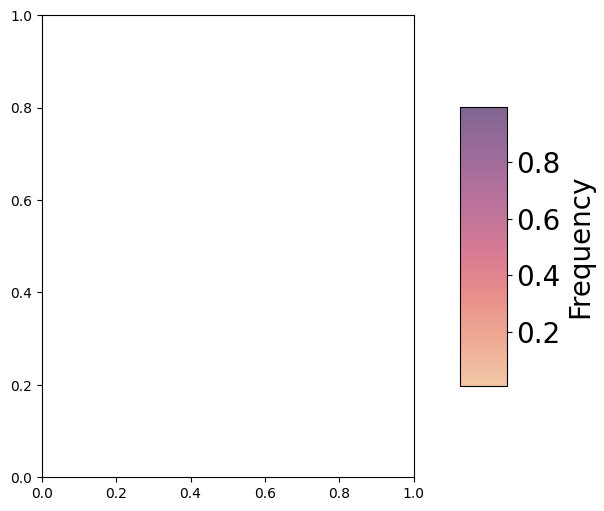

In [13]:
# Create smaller colorbar in the top right
# Can copy paste into top right of the above plot

fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)  # Adjusted total figsize
colorbar = plt.colorbar(scatter, ax=ax, 
                       fraction=0.1,     # Make colorbar smaller
                       pad=0.1,           # Adjust spacing from plot
                       location='right',
                       aspect=6) 
colorbar.set_label('Frequency', fontsize=fontsize)
colorbar.ax.tick_params(labelsize=labelsize)

if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, "cdss_best_r_eta_colorbar.jpg"), dpi=1000, bbox_inches='tight')

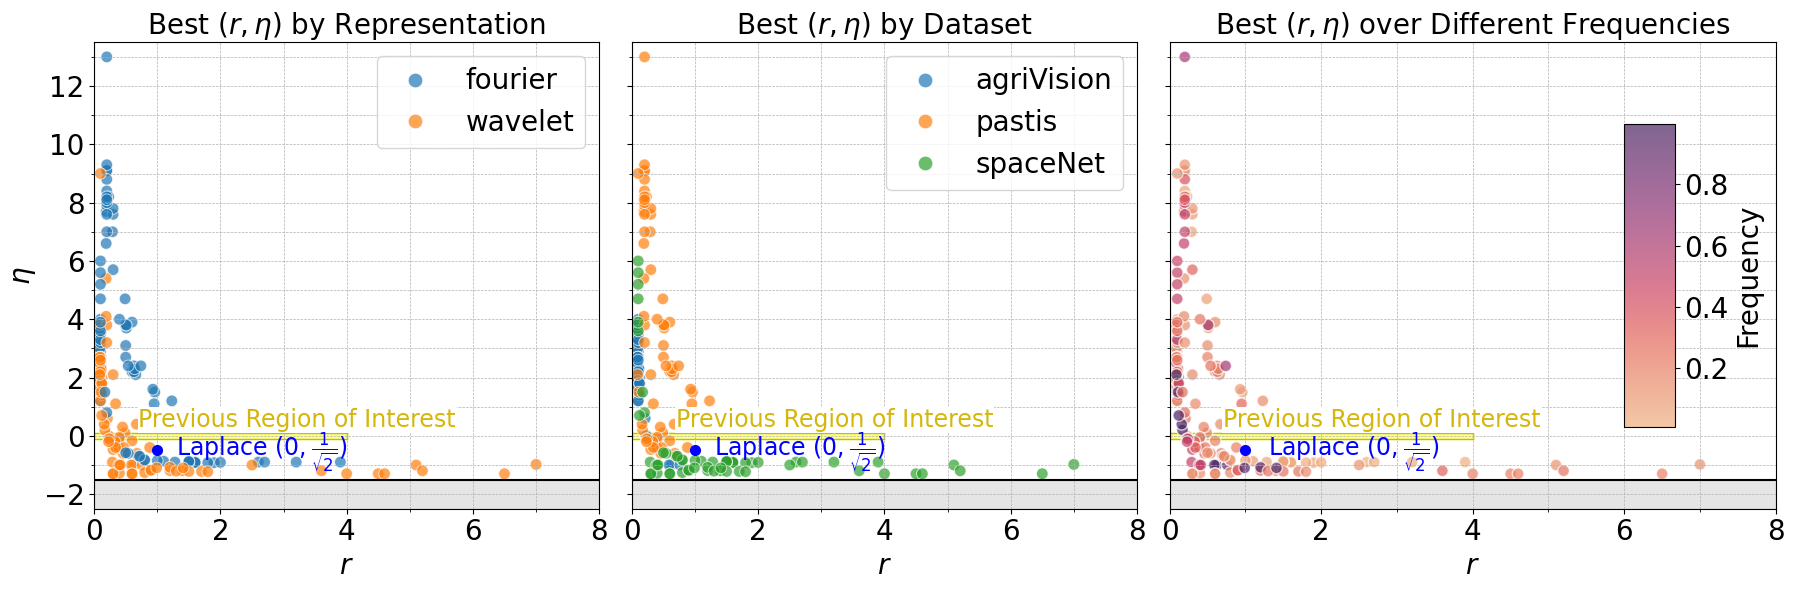

In [14]:
from matplotlib.ticker import MultipleLocator

colors = {
    'shaded_region': 'grey',
    'variance_level_set': 'green',
    'laplace': 'blue',
    'cauchy': 'xkcd:dark orange',
    'student_t': 'xkcd:dark orange',
    'axis_arrows': 'black',
    'annotation': 'black'
}

plot_config = {
    'x_limits': (0, 8),
    'y_limits': (-2.5, 13.5),
    'font_multiplier': 1,
    'font_addition': 5,
    'linewidth': 2,
    'figsize': (10, 6)
}

x_limits = plot_config['x_limits']
y_limits = plot_config['y_limits']
font_size = plot_config['font_multiplier']*12 + plot_config['font_addition']

label_r = r'$r$'
label_eta = r'$\eta$'
label_laplace = r'Laplace $(0, \frac{1}{\sqrt{2}})$'
label_student_t = r'Student t ($\nu=2$)'
label_cauchy = r'Cauchy (0, 1)'
label_variance_level_sets = 'Variance Level Sets'
label_previous_region_of_interest = 'Previous Region of Interest'
title_comparison = 'Comparison to Commonly Used Priors'

x_shade_roi = np.array([0, 4])
y_shade_roi = np.array([-0.1, 0.1])

temp = main_df
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # Adjusted total figsize

for ax in (ax1, ax2, ax3):
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xlabel(r'$r$', fontsize=fontsize)

    x_shade = np.array([0, plot_config['x_limits'][1]])
    y_shade = np.array([-1.5, -1.5])
    ax.fill_between(x_shade, plot_config['y_limits'][0], y_shade, color=colors['shaded_region'], alpha=0.2)
    ax.plot(x_shade, y_shade, 'k-', linewidth=1.5)

    x_shade = np.array([plot_config['x_limits'][0], 0])
    y_shade = np.array([-1.5, -1.5])
    ax.fill_between(x_shade, y_shade, plot_config['y_limits'][1], color=colors['shaded_region'], alpha=0.2)
    ax.plot(x_shade, y_shade, 'k-', linewidth=1.5)

    # Add Laplace
    ax.scatter(1, -0.5, color=colors['laplace'], linewidth=plot_config['linewidth'], zorder=10)
    ax.annotate(label_laplace, xy=(plot_config['x_limits'][1], -1), xytext=(1.3, -0.7), 
        textcoords='data', color=colors['laplace'], fontsize=font_size, zorder=10)
    
    # Add narrow lightly shaded yellow region
    ax.fill_between(x_shade_roi, y_shade_roi[0], y_shade_roi[1], color='yellow', alpha=0.4, zorder=0)
    ax.plot(x_shade_roi, [y_shade_roi[0], y_shade_roi[0]], 'y-', linewidth=1, zorder=0)
    ax.plot(x_shade_roi, [y_shade_roi[1], y_shade_roi[1]], 'y-', linewidth=1, zorder=0)

    # Add vertical bounding lines
    ax.plot([x_shade_roi[0], x_shade_roi[0]], y_shade_roi, 'y-', linewidth=1, zorder=0)
    ax.plot([x_shade_roi[1], x_shade_roi[1]], y_shade_roi, 'y-', linewidth=1, zorder=0)

    # Add annotation for the shaded region
    ax.annotate(label_previous_region_of_interest, xy=(1.5, 0), xytext=(0.7, 0.3),
        textcoords='data', color='xkcd:dark yellow', fontsize=font_size,
        bbox=dict(facecolor='white', edgecolor='none', pad=0.5))

sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='transform', ax=ax1, alpha=0.7, s=markersize)
ax1.set_title(r'Best ($r, \eta$) by Representation', fontsize=fontsize)
ax1.set_ylabel(r'$\eta$', fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)

sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='dataset', ax=ax2, alpha=0.7, s=markersize)
ax2.set_title(r'Best ($r, \eta$) by Dataset', fontsize=fontsize)
ax2.set_ylabel('', fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=labelsize)

# Create scatter plot with colormap instead of discrete colors
scatter = ax3.scatter(temp['best_r'], temp['best_eta'], 
                     c=temp['frequency'], 
                     cmap='flare',
                     s=markersize, 
                     alpha=0.7, edgecolor='white')  # Set color scale range

# Create smaller colorbar in the top right
colorbar = plt.colorbar(scatter, ax=ax3, 
                       fraction=0.1,     # Make colorbar smaller
                       pad=-0.3,           # Adjust spacing from plot
                       location='right',
                       aspect=6)           # Make colorbar more compact
colorbar.set_label('Frequency', fontsize=fontsize)
colorbar.ax.tick_params(labelsize=labelsize)

ax3.set_title(r'Best ($r, \eta$) over Different Frequencies', fontsize=fontsize)
ax3.set_ylabel('', fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=labelsize)

ax1.legend(markerscale=1.25, fontsize=fontsize)
ax2.legend(markerscale=1.25, fontsize=fontsize)
plt.tight_layout()
plt.show()

if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, "cdss_best_r_eta_with_colorbar.jpg"), dpi=1000, bbox_inches='tight')
